#### Importing Libraries

In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt

#### Load Ted's face

In [2]:
keanu = imread('keanu.jpg')

#### Create a list of sigma's to iterate over

In [28]:
sigmas = [20, 10, 5, 2, 1, 0.5]

Note: In the included document for the homework assignment, `fspecial()` for MATLAB took size of gaussian kernel as an argument (hsize), hence it was necessary to use the formula given in the slides $radius = 2*ceil(sigma)+1$. As of current versions of MATLAB `fspecial()` has been deprecated for `imgaussfilt()` which automatically implements filter size as given [here](https://www.mathworks.com/help/images/ref/imgaussfilt.html). Similarly, the equivalent function in Python that I'm using `skimage.filters.gaussian()` is a wrapper around `scipy.ndi.gaussian()` which implements the Gaussian filter similarly. Hence, there is no need to pass the second argument. [Source for Python function](https://github.com/scipy/scipy/blob/v0.14.0/scipy/ndimage/filters.py#L250)

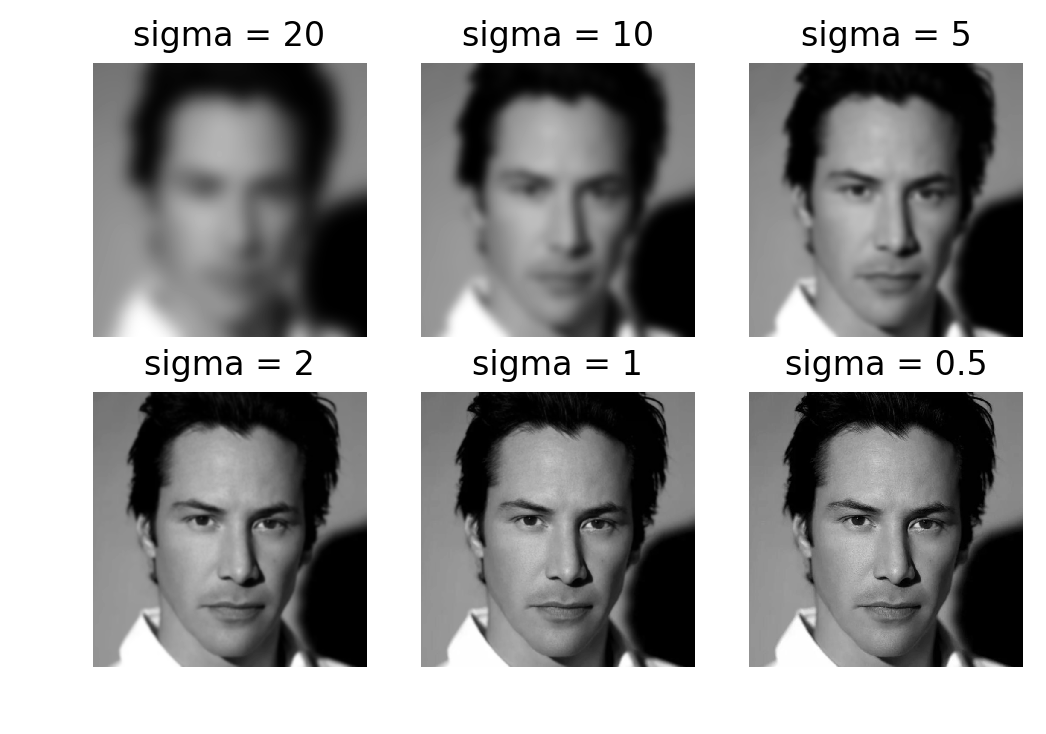

In [63]:
plt.close('all')
f, axarr = plt.subplots(2, 3, sharex='col', sharey='row', dpi=200)
for sigma in sigmas:
    filteredIm = gaussian(keanu, sigma)
    idx = sigmas.index(sigma)
    #print((int(idx/3), idx%3))
    axarr[int(idx/3), idx%3].axis('off')
    axarr[int(idx/3), idx%3].set_title(f'sigma = {sigma}')
    axarr[int(idx/3), idx%3].imshow(filteredIm, cmap = 'gray', aspect='auto')

## Optional: A Scanner Darkly Effect using Image Segmentation

Note: The effect used in the movie is actually a [cel-shading effect](https://www.wikiwand.com/en/Cel_shading), which is performed by computing the normals for world surfaces (which uses 3D models) and blending them with the Sobel operator (used for edges to give "Toon"-lines). Since, we work with a 2D image for our course, I will be using Image Segmentation to achieve a similar effect, albeit one that's more simplistic looking.

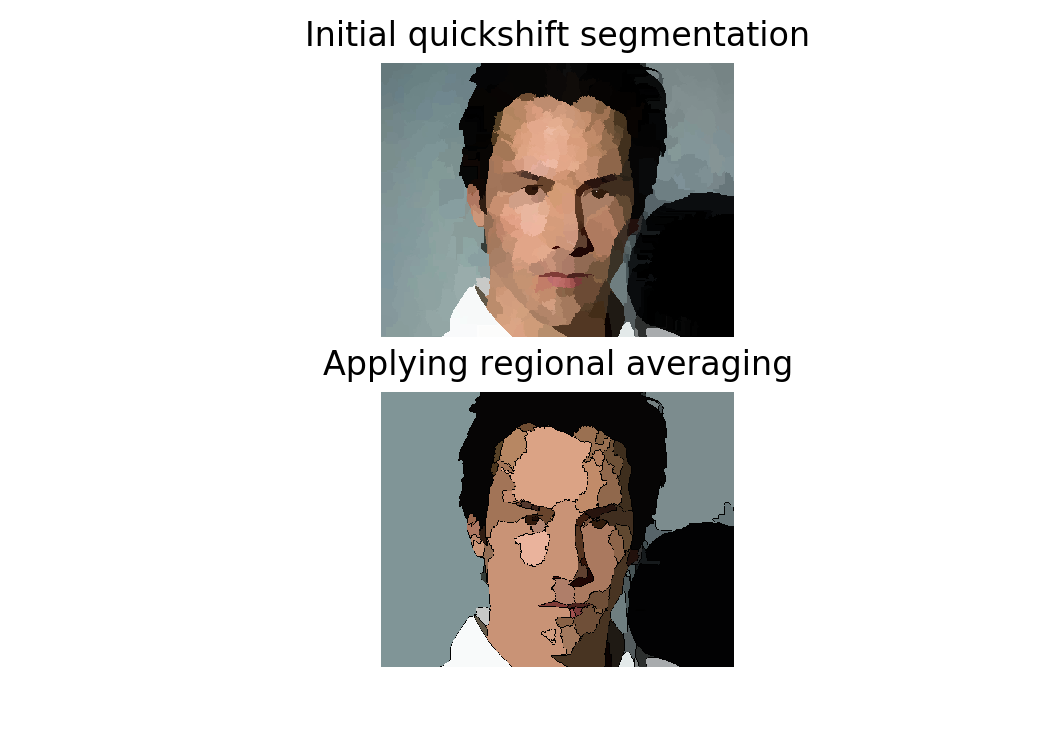

In [72]:
from skimage import data, io, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


keanu_colour = imread('keanu_colour.jpg')

labels1 = segmentation.quickshift(keanu_colour, kernel_size=7, max_dist=6, ratio=0.5)
out1 = color.label2rgb(labels1, keanu_colour, kind='avg')

g = graph.rag_mean_color(keanu_colour, labels1)
labels2 = graph.cut_threshold(labels1, g, 20)
out2 = color.label2rgb(labels2, keanu_colour, kind='avg')
out2 = segmentation.mark_boundaries(out2, labels2, (0, 0, 0))
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, dpi=200)

ax[0].imshow(out1)
ax[0].set_title('Initial quickshift segmentation')
ax[1].imshow(out2)
ax[1].set_title('Applying regional averaging')
for a in ax:
    a.axis('off')

#plt.tight_layout()